In [1]:
from fastai.imports  import *
from fastai.vision import *
from sklearn.metrics import roc_auc_score

In [2]:
df_labels = pd.read_csv("train_labels.csv")

In [3]:
df_labels.sample(3)

,id,label
82611,9149e1c41d80e09eee71e88b4477b5eea17ea568,1
119572,b2c9725c73d290b0e7aa22f89369e3f757581483,0
1022,3c34790f6503b0f617272a0f8f1af4838a540168,1


In [4]:
df_labels["id"] = df_labels.id+".tif"

In [5]:
df_labels.sample(3)

,id,label
163668,08fa18a5de0719916f4d65efa6cd3686250a2858.tif,1
46521,29cbaaa2b852a384447b56aebd2bf6768b1e228b.tif,1
142437,d6e345d5148aee33104541950d9584681fd9224f.tif,1


In [128]:
data = (ImageList.from_df(df_labels, "train")
             .split_by_rand_pct(0.2)
             .label_from_df("label")
             .transform(get_transforms(do_flip=True, max_rotate=25, max_zoom=2.))
             .databunch(bs=128)
             .normalize(imagenet_stats))

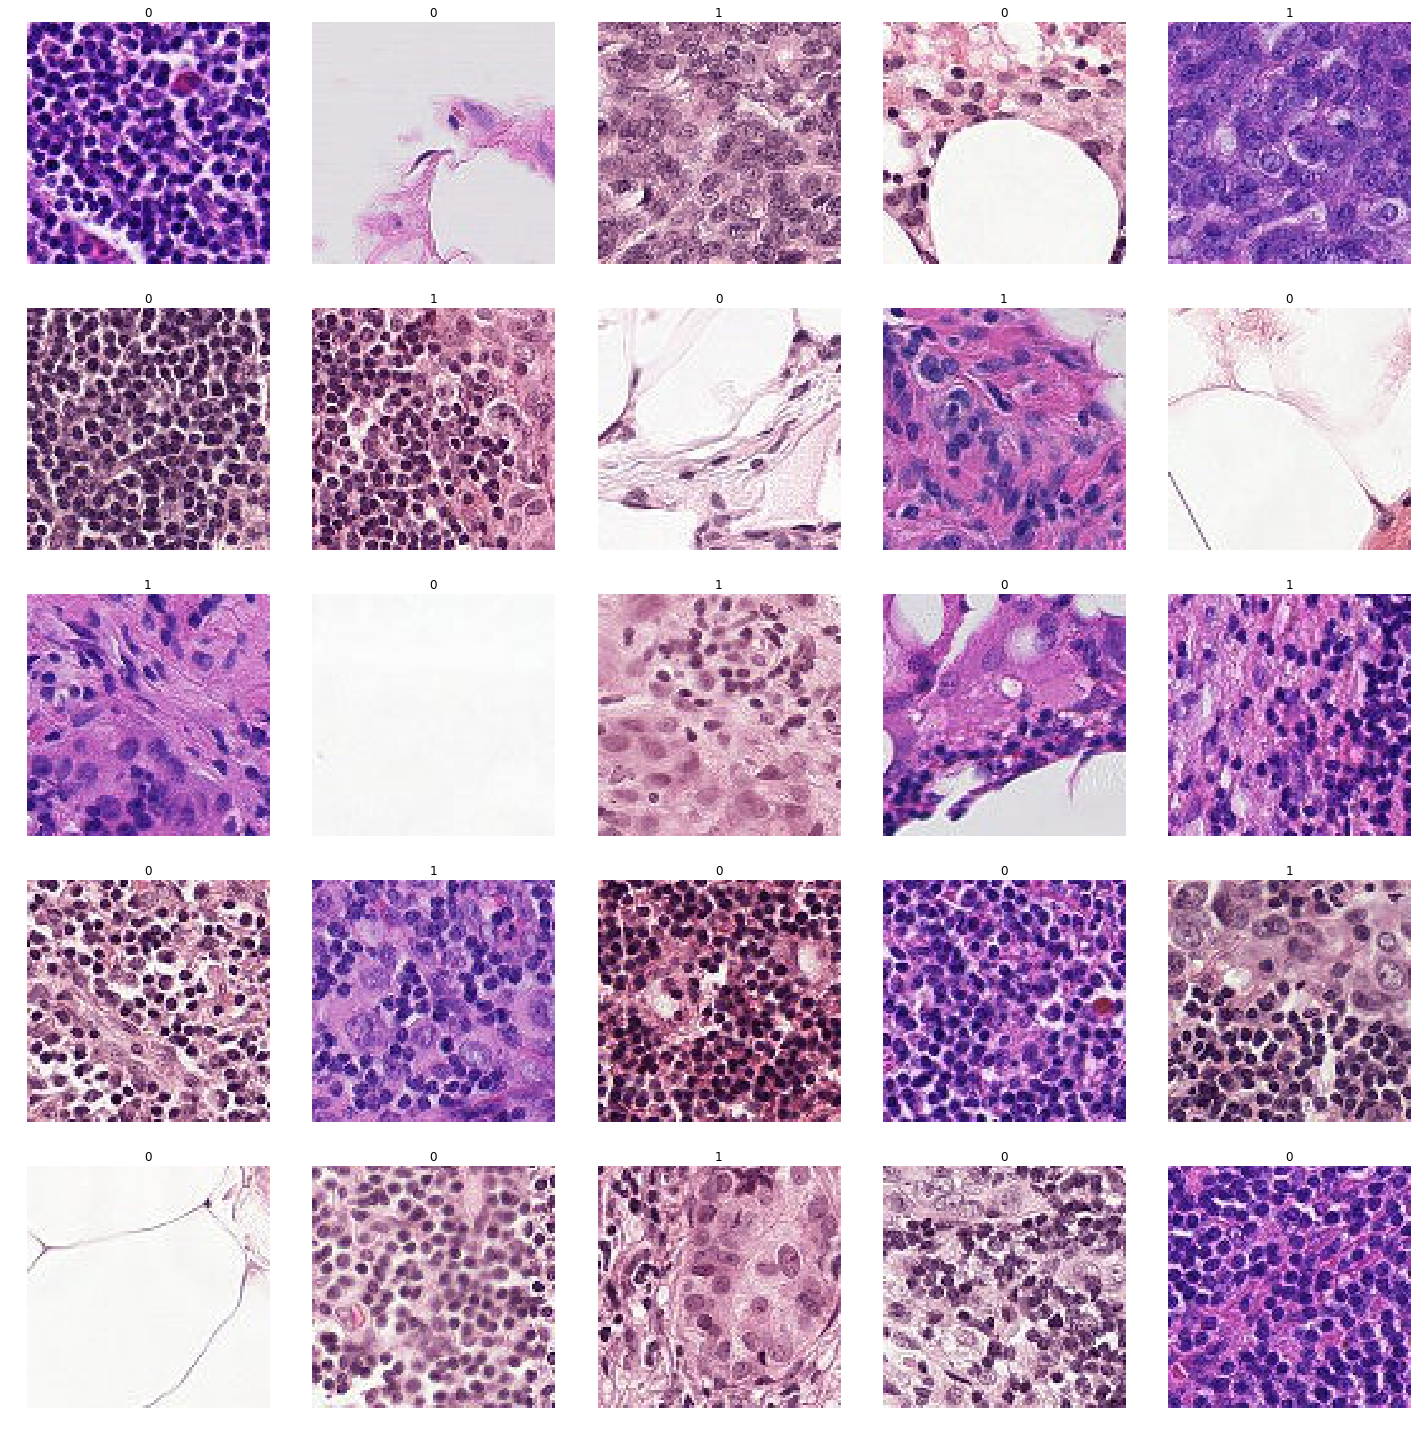

In [111]:
data.show_batch()

In [129]:
def auc_score(y_pred,y_true,tens=True):
    score=roc_auc_score(y_true,torch.sigmoid(y_pred)[:,1])
    if tens:
        score=tensor(score)
    else:
        score=score
    return score

In [134]:
learn = cnn_learner(data, models.densenet201, wd=0.1, metrics=[auc_score])

In [116]:
learn.loss=auc_score

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


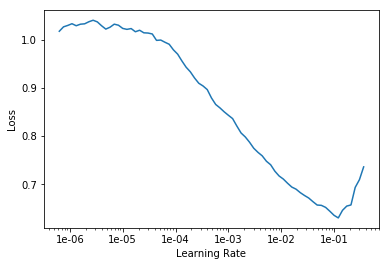

In [115]:
learn.lr_find()
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,auc_score,time
0,0.313035,0.264811,0.952078,07:15
1,0.245960,0.191780,0.974482,07:13
2,0.207752,0.150489,0.984271,07:15
3,0.200600,0.142815,0.986390,07:14
4,0.185374,0.130821,0.988144,07:13
5,0.172473,0.122511,0.989480,07:13
6,0.164694,0.122885,0.989425,07:13
7,0.152736,0.109491,0.991324,07:15
8,0.154747,0.109383,0.991264,07:13
9,0.147903,0.106897,0.991596,07:13


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


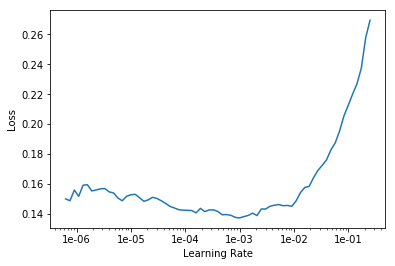

In [54]:
learn.lr_find()
learn.recorder.plot()

In [135]:
learn.load("stage-2")

Learner(data=ImageDataBunch;

Train: LabelList (176020 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
0,0,1,1,0
Path: train;

Valid: LabelList (44005 items)
x: ImageList
Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96),Image (3, 96, 96)
y: CategoryList
1,1,0,0,0
Path: train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace)
          (conv1): Conv2d(64, 128, kernel_s

In [77]:
learn.unfreeze()

In [79]:
learn.fit_one_cycle(2, max_lr=slice(1e-5, 1e-4), pct_start=0.8)

ZeroDivisionError: division by zero

In [74]:
learn.export()

In [56]:
interp=ClassificationInterpretation.from_learner(learn)

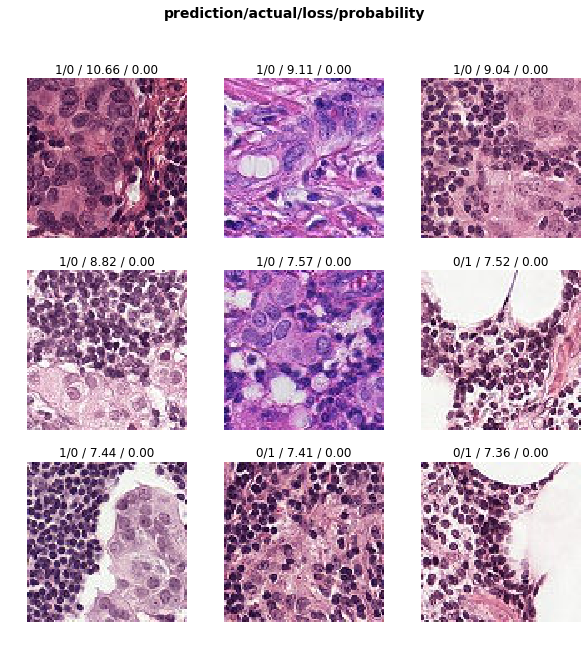

In [57]:
interp.plot_top_losses(9, figsize=(10, 10))

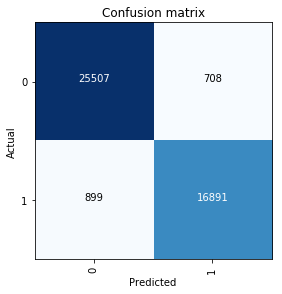

In [58]:
interp.plot_confusion_matrix()

In [104]:
fnames=get_image_files("test")
fbases=list(map(lambda x: x.name.split(".")[0], fnames))
files= pd.DataFrame(data=np.vstack((fnames, fbases)).T, index=range(0,len(fnames)), columns=["path", "base"]) 

In [101]:
np.vstack((fnames, fbases)).T.shape

(57458, 2)

In [105]:
files.head(5)

,path,base
0,test\00006537328c33e284c973d7b39d340809f7271b.tif,00006537328c33e284c973d7b39d340809f7271b
1,test\0000ec92553fda4ce39889f9226ace43cae3364e.tif,0000ec92553fda4ce39889f9226ace43cae3364e
2,test\00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,test\000253dfaa0be9d0d100283b22284ab2f6b643f6.tif,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,test\000270442cc15af719583a8172c87cd2bd9c7746.tif,000270442cc15af719583a8172c87cd2bd9c7746


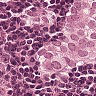

In [136]:
test=ImageImageList.from_df(files, ".")
test.get(0)

In [140]:
learn = load_learner("train", test=test)

In [141]:
preds,y = learn.TTA(ds_type=DatasetType.Test)

In [142]:
digits=np.argmax(preds, axis=1)

In [143]:
digits[:5]

tensor([1, 1, 1, 1, 0])

In [144]:
res_df = pd.DataFrame({'id': files.base, 'label': digits})
res_df.to_csv('submission.csv', index=False)